# Grid algorithm for a beta-binomial hierarchical model

[Bayesian Inference with PyMC](https://allendowney.github.io/BayesianInferencePyMC)

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install libraries
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install pymc3
    !pip install arviz
    !pip install empiricaldist

In [2]:
# PyMC generates a FutureWarning we don't need to deal with yet

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import matplotlib.pyplot as plt

def legend(**options):
    """Make a legend only if there are labels."""
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend(**options)

In [4]:
def decorate(**options):
    plt.gca().set(**options)
    legend()
    plt.tight_layout()

In [5]:
from empiricaldist import Cdf

def compare_cdf(pmf, sample):
    pmf.make_cdf().plot(label='grid')
    Cdf.from_seq(sample).plot(label='mcmc')
    print(pmf.mean(), sample.mean())
    decorate()

In [6]:
from empiricaldist import Pmf

def make_pmf(ps, qs, name):
    pmf = Pmf(ps, qs)
    pmf.normalize()
    pmf.index.name = name
    return pmf

## Heart Attack Data

This example is based on [Chapter 10 of *Probability and Bayesian Modeling*](https://bayesball.github.io/BOOK/bayesian-hierarchical-modeling.html#example-deaths-after-heart-attack); it uses data on death rates due to heart attack for patients treated at various hospitals in New York City.

We can use Pandas to read the data into a `DataFrame`.

In [7]:
import os

filename = 'DeathHeartAttackManhattan.csv'
if not os.path.exists(filename):
    !wget https://github.com/AllenDowney/BayesianInferencePyMC/raw/main/DeathHeartAttackManhattan.csv

In [8]:
import pandas as pd

df = pd.read_csv(filename)
df

,Hospital,Cases,Deaths,Death %
0,Bellevue Hospital Center,129,4,3.101
1,Harlem Hospital Center,35,1,2.857
2,Lenox Hill Hospital,228,18,7.894
3,Metropolitan Hospital Center,84,7,8.333
4,Mount Sinai Beth Israel,291,24,8.247
5,Mount Sinai Hospital,270,16,5.926
6,Mount Sinai Roosevelt,46,6,13.043
7,Mount Sinai St. Luke’s,293,19,6.485
8,NYU Hospitals Center,241,15,6.224
9,NYP Hospital - Allen Hospital,105,13,12.381


The columns we need are `Cases`, which is the number of patients treated at each hospital, and `Deaths`, which is the number of those patients who died.

In [9]:
data_ns = df['Cases'].values
data_ks = df['Deaths'].values

## Hospital Data with PyMC

Here's a hierarchical model that estimates the death rate for each hospital, and simultaneously estimates the distribution of rates across hospitals.

In [10]:
import pymc3 as pm

def make_model():
    with pm.Model() as model:
        alpha = pm.Gamma('alpha', alpha=4, beta=0.5)
        beta = pm.Gamma('beta', alpha=4, beta=0.5)
        xs = pm.Beta('xs', alpha, beta, shape=len(data_ns))
        ks = pm.Binomial('ks', n=data_ns, p=xs, observed=data_ks)
    return model

In [11]:
%time model = make_model()

CPU times: user 1.38 s, sys: 69.8 ms, total: 1.45 s
Wall time: 3.3 s


In [12]:
with model:
    %time trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [xs, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 3 seconds.


CPU times: user 7.39 s, sys: 203 ms, total: 7.59 s
Wall time: 9.69 s


Here's the graph representation of the model, showing that the observable is an array of 13 values.

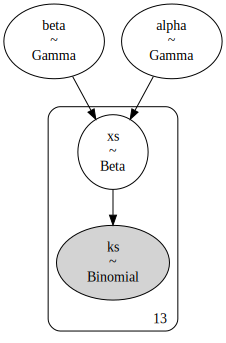

In [13]:
pm.model_to_graphviz(model)

Here are the posterior distributions of alpha and beta.

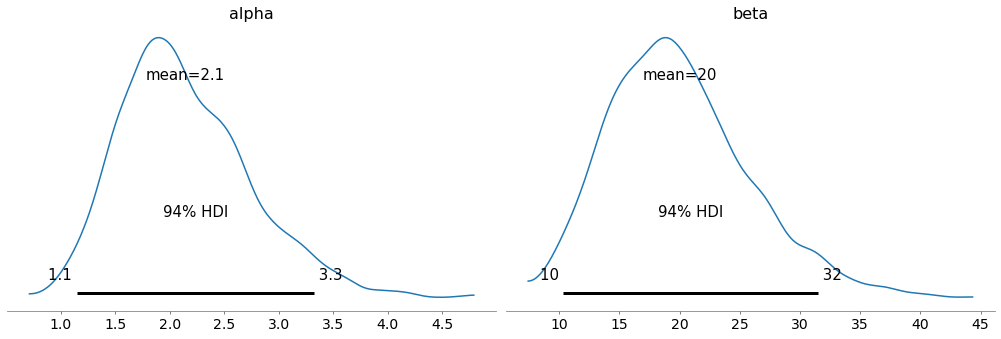

In [14]:
import arviz as az

with model:
    az.plot_posterior(trace, var_names=['alpha', 'beta'])

And we can extract the posterior distributions of the xs.

In [15]:
trace_xs = trace['xs'].transpose()
trace_xs.shape

(13, 2000)

As an example, here's the posterior distribution of x for the first hospital.

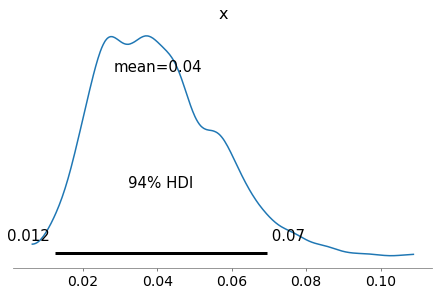

In [16]:
with model:
    az.plot_posterior(trace_xs[0])

## Just one update

In [17]:
i = 3
data_n = data_ns[i]
data_k = data_ks[i]

In [18]:
def make_model1():
    with pm.Model() as model1:
        alpha = pm.Gamma('alpha', alpha=4, beta=0.5)
        beta = pm.Gamma('beta', alpha=4, beta=0.5)
        x = pm.Beta('x', alpha, beta)
        k = pm.Binomial('k', n=data_n, p=x, observed=data_k)
    return model1

In [19]:
model1 = make_model1()
with model1:
    pred1 = pm.sample_prior_predictive(1000)
    trace1 = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.


Here's the graphical representation of the model.

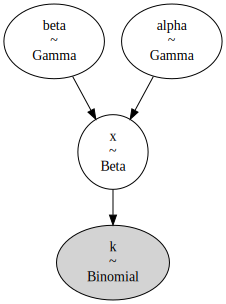

In [20]:
pm.model_to_graphviz(model1)

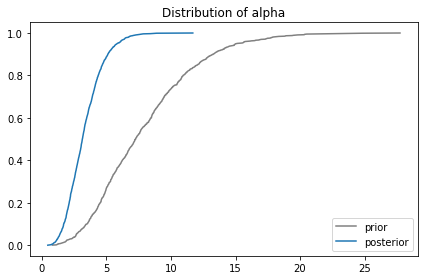

In [21]:
Cdf.from_seq(pred1['alpha']).plot(label='prior', color='gray')
Cdf.from_seq(trace1['alpha']).plot(label='posterior')
decorate(title='Distribution of alpha')

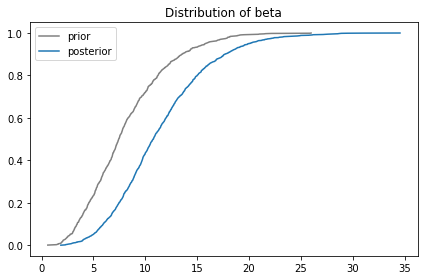

In [22]:
Cdf.from_seq(pred1['beta']).plot(label='prior', color='gray')
Cdf.from_seq(trace1['beta']).plot(label='posterior')
decorate(title='Distribution of beta')

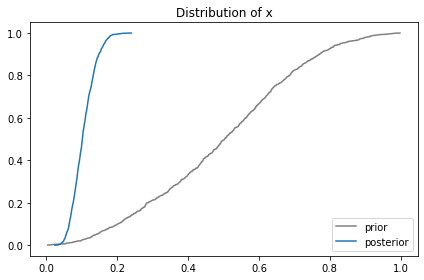

In [23]:
Cdf.from_seq(pred1['x']).plot(label='prior', color='gray')
Cdf.from_seq(trace1['x']).plot(label='posterior')
decorate(title='Distribution of x')

## The grid priors

In [24]:
import numpy as np
from scipy.stats import gamma

alpha = 4
beta = 0.5

alphas = np.linspace(0.1, 30, 100)
ps = gamma(alpha, scale=1/beta).pdf(alphas)
prior_alpha = make_pmf(ps, alphas, 'alpha')

7.9951208971163545 7.917766378660901


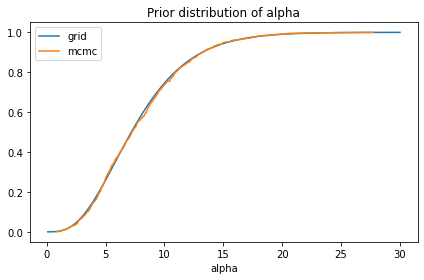

In [25]:
compare_cdf(prior_alpha, pred1['alpha'])
decorate(title='Prior distribution of alpha')

In [26]:
betas = np.linspace(0.1, 50, 90)
ps = gamma(alpha, scale=1/beta).pdf(betas)
prior_beta = make_pmf(ps, betas, 'beta')

7.999987656838361 8.09269323521205


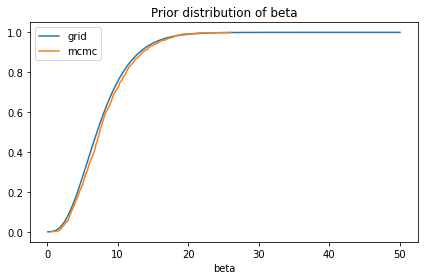

In [27]:
compare_cdf(prior_beta, pred1['beta'])
decorate(title='Prior distribution of beta')

## The joint distribution of hyperparameters

In [28]:
def make_hyper(prior_alpha, prior_beta):
    PA, PB = np.meshgrid(prior_alpha.ps, prior_beta.ps, indexing='ij')
    hyper = PA * PB
    return hyper

In [29]:
prior_hyper = make_hyper(prior_alpha, prior_beta)
prior_hyper.shape

(100, 90)

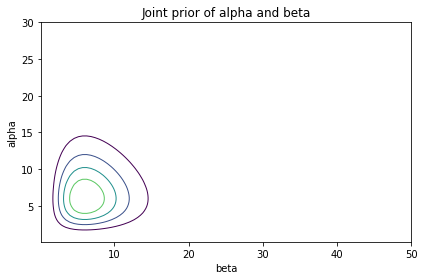

In [30]:
import pandas as pd
from utils import plot_contour

plot_contour(pd.DataFrame(prior_hyper, 
                          index=prior_alpha.index, 
                          columns=prior_beta.index))
decorate(title="Joint prior of alpha and beta")

In [31]:
(prior_hyper == 0).sum()

0

## Joint prior of alpha, beta, and x

In [99]:
A, B, X = np.meshgrid(alphas, betas, xs, indexing='ij')

In [124]:
from scipy.stats import beta as betadist

%time betapdf = betadist.pdf(X, A, B)

CPU times: user 446 ms, sys: 0 ns, total: 446 ms
Wall time: 445 ms


We can speed this up by computing just $x^{\alpha-1} (1-x)^{\beta-1}$ and skipping the terms that don't depend on x

In [125]:
xs = np.linspace(0.01, 0.99, 99)
logx = np.log(xs)
logy = np.log(1-xs)

In [126]:
logpdf = (A-1) * logx + (B-1) * logy
betapdf = np.exp(logpdf)

In [127]:
totals = betapdf.sum(axis=2)

In [128]:
shape = totals.shape + (1,)
betapdf /= totals.reshape(shape)

In [129]:
def make_prior(hyper):

    # reshape hyper so we can multiply along axis 0
    shape = hyper.shape + (1,)
    prior = betapdf * hyper.reshape(shape)

    return prior

In [130]:
%time prior = make_prior(prior_hyper)
prior.sum()

CPU times: user 3.07 ms, sys: 0 ns, total: 3.07 ms
Wall time: 1.74 ms


1.0000000000000002

The following function computes the marginal distributions.

In [131]:
def marginal(joint, axis):
    axes = [i for i in range(3) if i != axis]
    return joint.sum(axis=tuple(axes))

And let's confirm that the marginal distributions are what they are supposed to be.

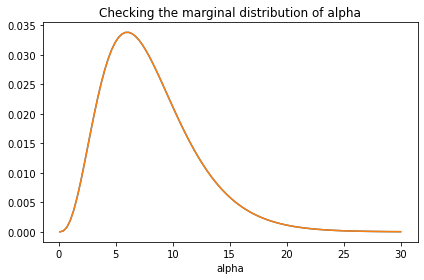

In [132]:
prior_alpha.plot()
marginal_alpha = Pmf(marginal(prior, 0), prior_alpha.qs)
marginal_alpha.plot()
decorate(title='Checking the marginal distribution of alpha')

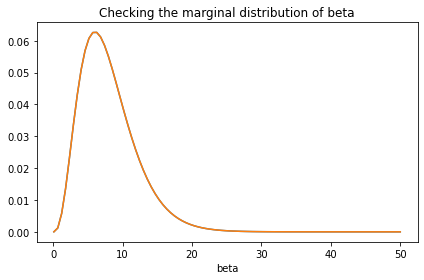

In [133]:
prior_beta.plot()
marginal_beta = Pmf(marginal(prior, 1), prior_beta.qs)
marginal_beta.plot()
decorate(title='Checking the marginal distribution of beta')

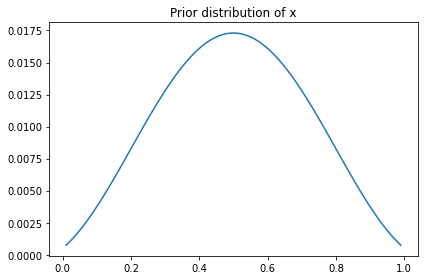

In [134]:
prior_x = Pmf(marginal(prior, 2), xs)
prior_x.plot()
decorate(title='Prior distribution of x')

0.49993928870480525 0.49485039118003554


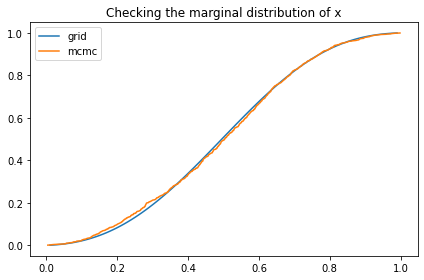

In [135]:
marginal_x = Pmf(marginal(prior, 2), xs)
compare_cdf(marginal_x, pred1['x'])
decorate(title='Checking the marginal distribution of x')

In [136]:
def get_hyper(joint):
    return joint.sum(axis=2)

In [137]:
hyper = get_hyper(prior)

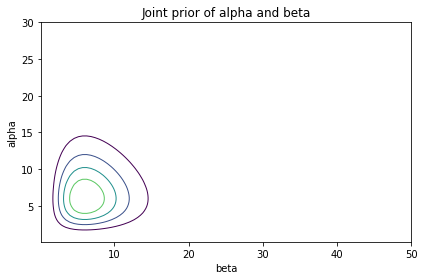

In [138]:
plot_contour(pd.DataFrame(hyper, 
                          index=prior_alpha.index, 
                          columns=prior_beta.index))
decorate(title="Joint prior of alpha and beta")

## The Update

In [139]:
from scipy.stats import binom

like_x = binom.pmf(data_k, data_n, xs)
like_x.shape

(99,)

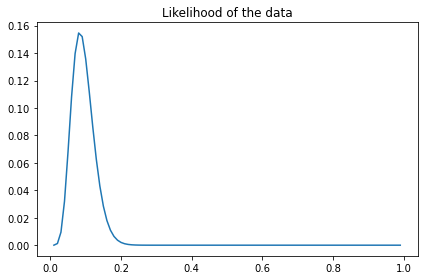

In [140]:
plt.plot(xs, like_x)
decorate(title='Likelihood of the data')

In [141]:
def update(prior, data):
    n, k = data
    like_x = binom.pmf(k, n, xs)

    posterior = prior * like_x
    posterior /= posterior.sum()
    return posterior

In [142]:
data = data_n, data_k
%time posterior = update(prior, data)

CPU times: user 5.23 ms, sys: 519 µs, total: 5.75 ms
Wall time: 3.77 ms


3.2856128520948427 3.3155246120581516


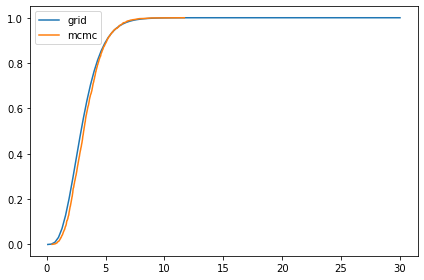

In [143]:
marginal_alpha = Pmf(marginal(posterior, 0), prior_alpha.qs)
compare_cdf(marginal_alpha, trace1['alpha'])

11.371776635028473 11.425641515921367


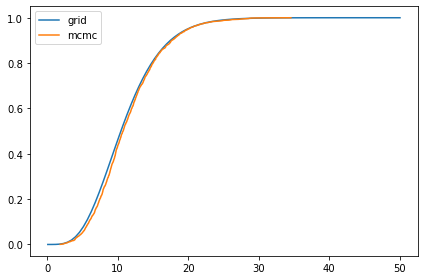

In [144]:
marginal_beta = Pmf(marginal(posterior, 1), prior_beta.qs)
compare_cdf(marginal_beta, trace1['beta'])

0.1041084094915888 0.10428490774307435


(0.1041084094915888, 0.10428490774307435)

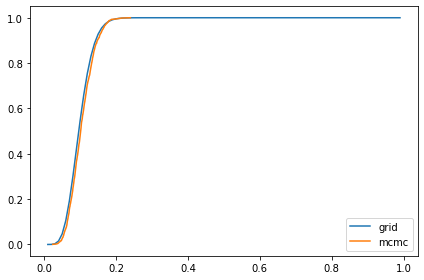

In [145]:
marginal_x = Pmf(marginal(posterior, 2), xs)
compare_cdf(marginal_x, trace1['x'])
marginal_x.mean(), trace1['x'].mean()

In [146]:
posterior_hyper = get_hyper(posterior)

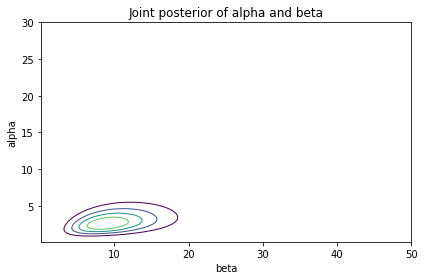

In [147]:
plot_contour(pd.DataFrame(posterior_hyper, 
                          index=prior_alpha.index, 
                          columns=prior_beta.index))
decorate(title="Joint posterior of alpha and beta")

In [148]:
like_hyper = posterior_hyper / prior_hyper

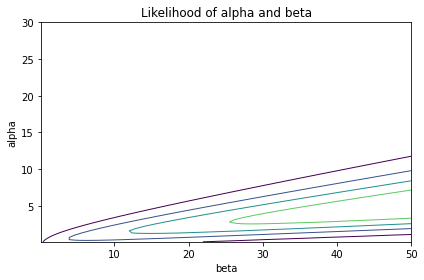

In [149]:
plot_contour(pd.DataFrame(like_hyper, 
                          index=prior_alpha.index, 
                          columns=prior_beta.index))
decorate(title="Likelihood of alpha and beta")

## Multiple updates

In [150]:
prior = make_prior(prior_hyper)
prior.shape

(100, 90, 99)

In [151]:
def multiple_updates(prior, ns, ks, xs):
    for data in zip(ns, ks):
        print(data)
        posterior = update(prior, data)
        hyper = get_hyper(posterior)
        prior = make_prior(hyper)
    return posterior

In [152]:
%time posterior = multiple_updates(prior, data_ns, data_ks, xs)

(129, 4)
(35, 1)
(228, 18)
(84, 7)
(291, 24)
(270, 16)
(46, 6)
(293, 19)
(241, 15)
(105, 13)
(353, 25)
(250, 11)
(41, 4)
CPU times: user 89.5 ms, sys: 2.11 ms, total: 91.6 ms
Wall time: 84.8 ms


2.07427996138189 2.1435754401946


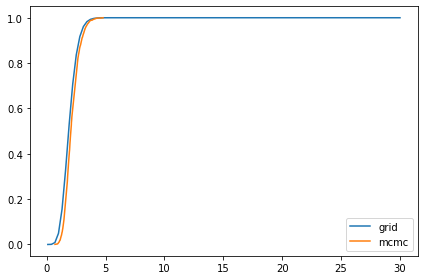

In [153]:
marginal_alpha = Pmf(marginal(posterior, 0), prior_alpha.qs)
compare_cdf(marginal_alpha, trace['alpha'])

19.733097523103417 20.00322135413212


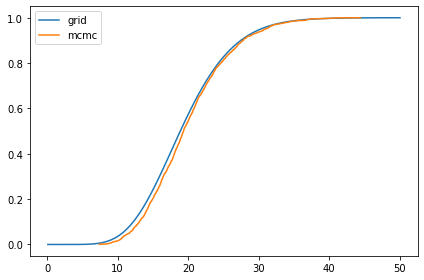

In [154]:
marginal_beta = Pmf(marginal(posterior, 1), prior_beta.qs)
compare_cdf(marginal_beta, trace['beta'])

0.09691515559896688 0.09940812268045761


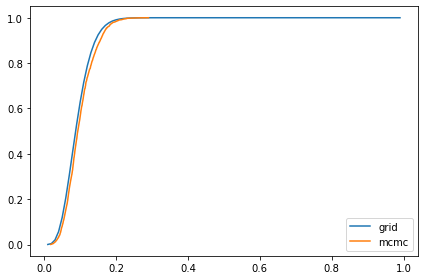

In [155]:
marginal_x = Pmf(marginal(posterior, 2), prior_x.qs)
compare_cdf(marginal_x, trace_xs[-1])

In [156]:
posterior_hyper = get_hyper(posterior)

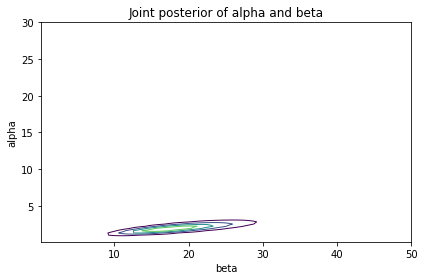

In [157]:
plot_contour(pd.DataFrame(posterior_hyper, 
                          index=prior_alpha.index, 
                          columns=prior_beta.index))
decorate(title="Joint posterior of alpha and beta")

In [158]:
like_hyper = posterior_hyper / prior_hyper

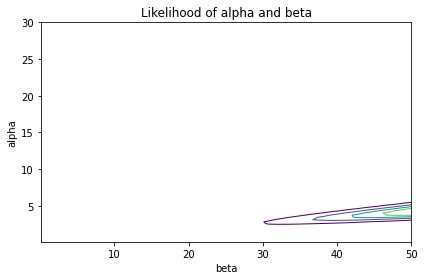

In [159]:
plot_contour(pd.DataFrame(like_hyper, 
                          index=prior_alpha.index, 
                          columns=prior_beta.index))
decorate(title="Likelihood of alpha and beta")

## One at a time

In [172]:
def compute_likes_hyper(ns, ks):
    shape = ns.shape + alphas.shape + betas.shape
    likes_hyper = np.empty(shape)
    
    for i, data in enumerate(zip(ns, ks)):
        print(data)
        n, k = data
        like_x = binom.pmf(k, n, xs)
        posterior = betapdf * like_x
        likes_hyper[i] = posterior.sum(axis=2)
        print(likes_hyper[i].sum())
    return likes_hyper

In [173]:
%time likes_hyper = compute_likes_hyper(data_ns, data_ks)

(129, 4)
78.60007958494744
(35, 1)
284.93055938180265
(228, 18)
40.51620266965634
(84, 7)
111.68094380239177
(291, 24)
31.809110163739227
(270, 16)
33.99737117139793
(46, 6)
223.17381165788373
(293, 19)
31.264495041430255
(241, 15)
38.06916056118402
(105, 13)
95.02635242797895
(353, 25)
25.96108004696818
(250, 11)
37.69637422099334
(41, 4)
237.05450884067145
CPU times: user 36 ms, sys: 1.27 ms, total: 37.3 ms
Wall time: 31.2 ms


In [174]:
likes_hyper.sum()

1269.780049571045

In [175]:
like_hyper_all = likes_hyper.prod(axis=0)
like_hyper_all.sum()

4.8075588448273426e-15

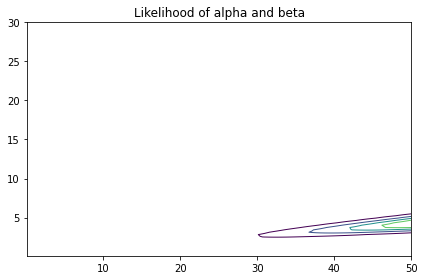

In [176]:
plot_contour(pd.DataFrame(like_hyper_all, 
                          index=alphas, 
                          columns=betas))
decorate(title="Likelihood of alpha and beta")

In [177]:
posterior_hyper_all = prior_hyper * like_hyper_all
posterior_hyper_all /= posterior_hyper_all.sum()

np.allclose(posterior_hyper_all, posterior_hyper)

True

True

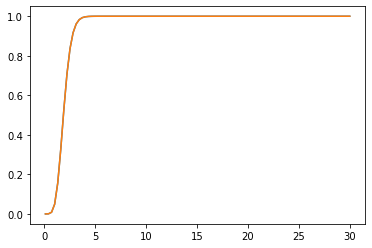

In [178]:
marginal_alpha2 = Pmf(posterior_hyper_all.sum(axis=1), prior_alpha.qs)
marginal_alpha2.make_cdf().plot()
marginal_alpha.make_cdf().plot()
np.allclose(marginal_alpha, marginal_alpha2)

True

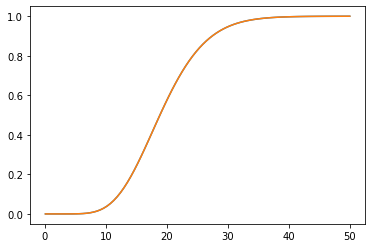

In [179]:
marginal_beta2 = Pmf(posterior_hyper_all.sum(axis=0), prior_beta.qs)
marginal_beta2.make_cdf().plot()
marginal_beta.make_cdf().plot()
np.allclose(marginal_beta, marginal_beta2)

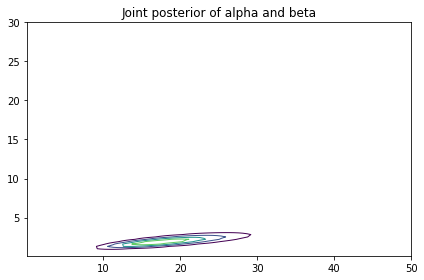

In [180]:
plot_contour(pd.DataFrame(posterior_hyper_all, 
                          index=alphas, 
                          columns=betas))
decorate(title="Joint posterior of alpha and beta")

In [181]:
i = 3
data = data_ns[i], data_ks[i]
data

(84, 7)

In [182]:
hyper_i = prior_hyper * like_hyper_all / likes_hyper[i]
hyper_i.sum()

5.2151350253323626e-20

In [183]:
prior_i = make_prior(hyper_i) 

In [184]:
posterior_i = update(prior_i, data)

<AxesSubplot:>

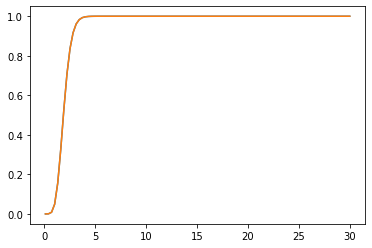

In [185]:
Pmf(marginal(posterior_i, 0), prior_alpha.qs).make_cdf().plot()
marginal_alpha.make_cdf().plot()

<AxesSubplot:>

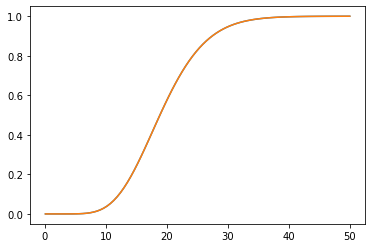

In [186]:
Pmf(marginal(posterior_i, 1), prior_beta.qs).make_cdf().plot()
marginal_beta.make_cdf().plot()

In [187]:
marginal_alpha = Pmf(marginal(posterior_i, 0), prior_alpha.qs)
marginal_beta = Pmf(marginal(posterior_i, 1), prior_beta.qs)
marginal_x = Pmf(marginal(posterior_i, 2), prior_x.qs)

2.0742799613818907 2.1435754401946


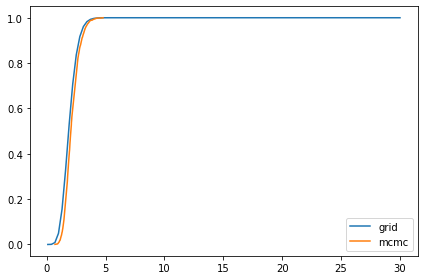

In [188]:
compare_cdf(marginal_alpha, trace['alpha'])

19.73309752310342 20.00322135413212


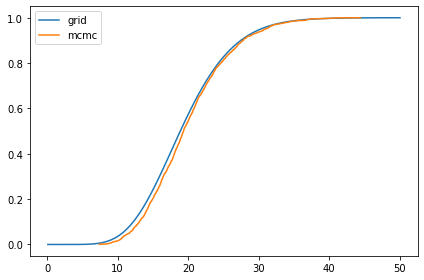

In [189]:
compare_cdf(marginal_beta, trace['beta'])

0.08579379045971264 0.0860216969193682


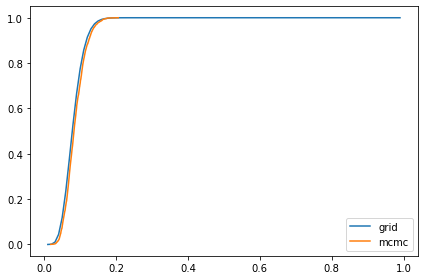

In [190]:
compare_cdf(marginal_x, trace_xs[i])

In [191]:
def compute_all_marginals(ns, ks):
    prior = prior_hyper * like_hyper_all
    
    for i, data in enumerate(zip(ns, ks)):
        print(data)
        n, k = data
        hyper_i = prior / likes_hyper[i]
        prior_i = make_prior(hyper_i) 
        posterior_i = update(prior_i, data)
        marginal_x = Pmf(marginal(posterior_i, 2), xs)
        marginal_x.make_cdf().plot()

(129, 4)
(35, 1)
(228, 18)
(84, 7)
(291, 24)
(270, 16)
(46, 6)
(293, 19)
(241, 15)
(105, 13)
(353, 25)
(250, 11)
(41, 4)
CPU times: user 211 ms, sys: 176 ms, total: 387 ms
Wall time: 186 ms


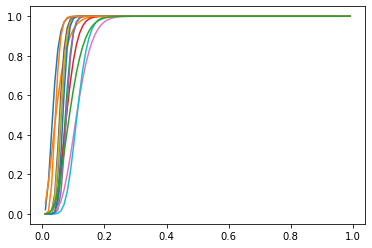

In [192]:
%time compute_all_marginals(data_ns, data_ks)